In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
df=pd.read_csv("data/L030_TI_High_VEL020_fs1000.csv")
df.head()

,t [s],az NO FLAT [m/s2],az WITH FLAT [m/s2]
0,5.670,-9.80999,-9.80999
1,5.671,-9.80999,-9.80999
2,5.672,-9.80999,-9.80999
3,5.673,-9.80999,-9.80999
4,5.674,-9.80999,-9.80999


In [3]:
t = df['t [s]'].to_numpy()
az_no_flat = df['az NO FLAT [m/s2]'].to_numpy()
az_with_flat = df['az WITH FLAT [m/s2]'].to_numpy()

print('Mean az no flat:',np.mean(az_no_flat))
print('Mean az flat:', np.mean(az_with_flat))

az_no_flat = az_no_flat - np.mean(az_no_flat)
az_with_flat = az_with_flat - np.mean(az_with_flat)

fs=1e3
#fs=1/np.mean(np.diff(t))
print('Sampling freq:',fs,'Hz')
N=len(t)
print('Number of samples:', N)


v=20e3/3600
print('Lineal velocity:',v,'m/s')
r=0.46
print('Radius:',r,'m')
fr=v/(2*np.pi*r)
print('Rotational freq:',fr,'Hz')

Mean az no flat: -9.809570537387504
Mean az flat: -9.81345842531758
Sampling freq: 1000.0 Hz
Number of samples: 27001
Lineal velocity: 5.555555555555555 m/s
Radius: 0.46 m
Rotational freq: 1.9221611484528422 Hz


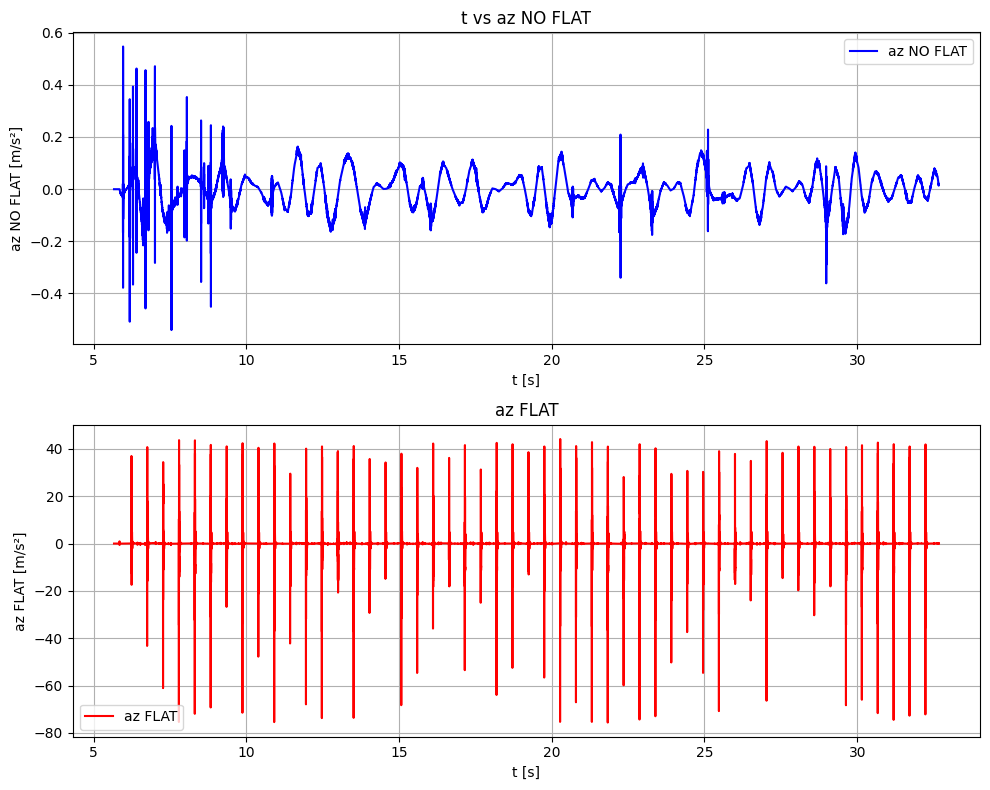

In [4]:
# Crear los subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Primer subplot: t vs az_no_flat_array
axs[0].plot(t, az_no_flat, label='az NO FLAT', color='b')
axs[0].set_title('t vs az NO FLAT')
axs[0].set_xlabel('t [s]')
axs[0].set_ylabel('az NO FLAT [m/s²]')
axs[0].grid(True)
axs[0].legend()

# Segundo subplot: az_no_flat_array
axs[1].plot(t,az_with_flat, label='az FLAT', color='r')
axs[1].set_title('az FLAT')
axs[1].set_xlabel('t [s]')
axs[1].set_ylabel('az FLAT [m/s²]')
axs[1].grid(True)
axs[1].legend()

# Ajustar el layout
plt.tight_layout()

# Mostrar los gráficos
plt.show()

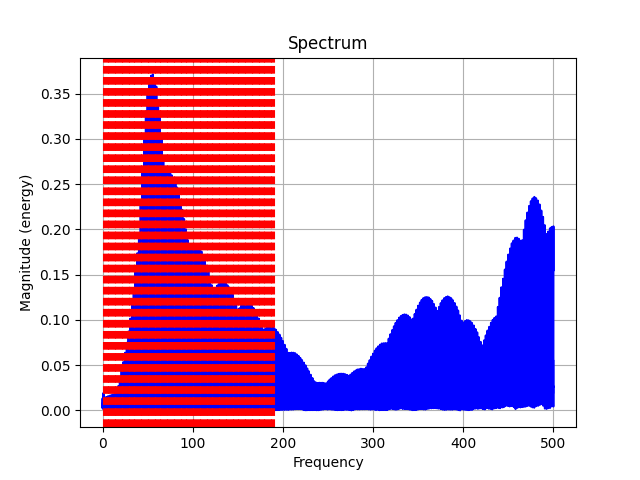

Max freq: 55.77571201066627


In [5]:
plt.close('all')
%matplotlib widget 
plt.title("Spectrum")
spectrum=plt.magnitude_spectrum(az_with_flat, Fs=fs, color='blue')
for i in range(1, 100):
    plt.axvline(x=i*fr, color='red', linestyle='--', label=f'{i}*fr' if i == 1 else None)
plt.grid(True)
plt.show()

print('Max freq:',spectrum[1][np.argmax(spectrum[0])])


In [6]:
spectrum[1][np.argmax(spectrum[0])]/fr

np.float64(29.017188311999977)

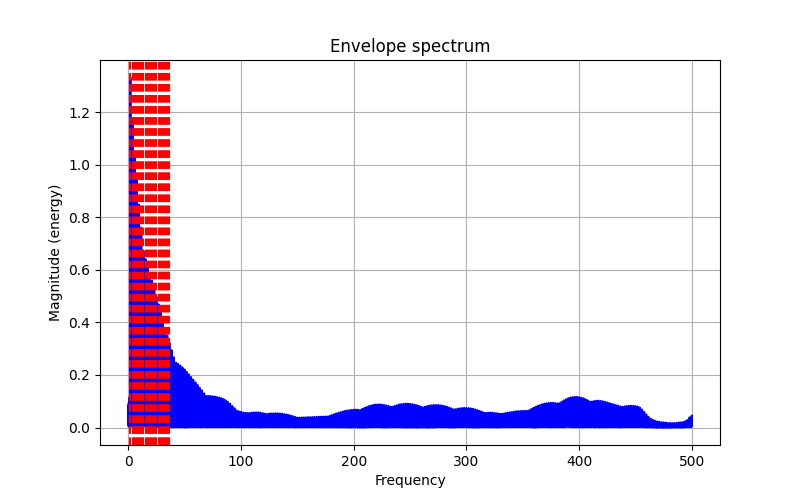

In [7]:
plt.close('all')
Sx_flax_env=np.abs(signal.hilbert(az_with_flat))
%matplotlib widget 
#%matplotlib inline
plt.figure(figsize=(8,5))
plt.title("Envelope spectrum")
spectrum=plt.magnitude_spectrum(Sx_flax_env-np.mean(Sx_flax_env), Fs=fs, color='blue')
for i in range(1, 20):
    plt.axvline(x=i*fr, color='red', linestyle='--', label=f'{i}*fr' if i == 1 else None)
plt.grid(True)
#plt.savefig('prueba_rm.pdf',bbox_inches='tight')
plt.show()


In [8]:
instantaneous_phase = np.unwrap(np.angle(signal.hilbert(az_with_flat)))
instantaneous_frequency = np.diff(instantaneous_phase) * fs / (2.0 * np.pi)
print(np.mean(instantaneous_frequency),np.std(instantaneous_frequency))
print(len(instantaneous_frequency))

"""
plt.close('all')
%matplotlib widget
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(instantaneous_frequency)) / fs, instantaneous_frequency)
plt.title('Frecuencia Instantánea')
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.grid(True)
plt.show()
"""

7.722490385718342 423.12500166832916
27000


"\nplt.close('all')\n%matplotlib widget\nplt.figure(figsize=(10, 6))\nplt.plot(np.arange(len(instantaneous_frequency)) / fs, instantaneous_frequency)\nplt.title('Frecuencia Instantánea')\nplt.xlabel('Tiempo [s]')\nplt.ylabel('Frecuencia [Hz]')\nplt.grid(True)\nplt.show()\n"

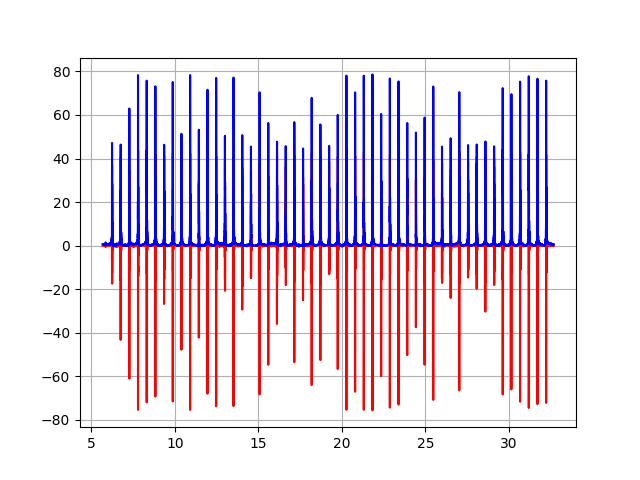

In [9]:
plt.close('all')
%matplotlib widget
plt.plot(t,az_with_flat, label='az FLAT', color='r')
plt.plot(t,Sx_flax_env, label='Envelope', color='b')
plt.grid(True)
plt.show()

### Simulating signal

#### Model: 

$y(k)=\sum_{r}A_r\sin\left(2\pi f\left[\dfrac{k}{F}-\dfrac{r}{f_m}\right]\right)\cdot e^{-\beta(L)\left(\dfrac{k}{F}-\dfrac{r}{f_m}\right)}\cdot u\left(\dfrac{k}{F}-\dfrac{r}{f_m}\right)$